## Step 1 : Dataset Creation ##

There are 200 images of each category (cats, dogs and foxes) downloaded via the free flickr api which is being used as the dataset for this assignment

## Step 2 and 3 : Data splitting and preprocessing ##

First, this code applies preprocessing to a dataset of images using `torchvision.transforms`. The training images are resized to 128x128 pixels, augmented with random horizontal flips and color adjustments, then converted to tensors and normalized. The test images are only resized and normalized. The dataset is organized into categories (cats, dogs, and foxes) and split into 80% training and 20% testing using `train_test_split` from `sklearn`. The `Subset` method is used to create training and test datasets, which are loaded in batches of 32 using `DataLoader`. The data is shuffled during training to ensure better generalization, and the sizes of the training and test sets are printed for verification.

In [3]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),                 # Resize all images to 128x128 pixels
    transforms.RandomHorizontalFlip(p=0.5),        # Randomly flip images horizontally with a probability of 50%
    #transforms.RandomRotation(degrees=15),         # Randomly rotate images by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly adjust brightness, contrast, etc.
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))           # Normalize pixel values to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),                 # Resize all images to 128x128 pixels
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))           # Normalize pixel values to [-1, 1]
])

train_dataset = datasets.ImageFolder(root='/Users/shabarivignesh/Data 255 - Deep Learning/flickr_images/', transform=train_transform)
test_dataset = datasets.ImageFolder(root='/Users/shabarivignesh/Data 255 - Deep Learning/flickr_images/', transform=test_transform)

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

dogs_train_idx, dogs_test_idx = train_test_split(dogs_indices, test_size=0.2, random_state=42)
cats_train_idx, cats_test_idx = train_test_split(cats_indices, test_size=0.2, random_state=42)
foxs_train_idx, foxs_test_idx = train_test_split(foxs_indices, test_size=0.2, random_state=42)

train_indices = dogs_train_idx + cats_train_idx + foxs_train_idx
test_indices = dogs_test_idx + cats_test_idx + foxs_test_idx

train_dataset = Subset(datasets.ImageFolder(root='/Users/shabarivignesh/Data 255 - Deep Learning/flickr_images/', transform=train_transform), train_indices)
test_dataset = Subset(datasets.ImageFolder(root='/Users/shabarivignesh/Data 255 - Deep Learning/flickr_images/', transform=test_transform), test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")


Training set size: 482
Test set size: 121


## Step 4 : Building a simple CNN ##

This code defines a simple Convolutional Neural Network (CNN) using PyTorch for image classification with three output classes (e.g., cats, dogs, and foxes). The CNN consists of two convolutional layers with batch normalization and ReLU activation, followed by max-pooling for downsampling. After flattening the output, a fully connected layer with dropout is applied to reduce overfitting. The final layer outputs predictions for the three classes. The loss function used is `CrossEntropyLoss`, which is standard for multi-class classification, and the optimizer is `AdamW`, which incorporates weight decay for regularization to prevent overfitting. The learning rate is set to 0.0001.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 32 * 32, out_features=128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=3)
    
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 32 * 32)  # Flatten the tensor
        x = self.dropout(nn.ReLU()(self.fc1(x)))
      
        x = self.fc2(x)
        return x

model = SimpleCNN()

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)


## Step 5 : Training the model and making predictions ##

This code implements the training and evaluation loop for CNN model over 20 epochs. In each epoch, the model is trained by processing batches of images from the training set, computing the loss using cross-entropy, backpropagating the gradients, and updating the weights using the AdamW optimizer. After each epoch, the model is evaluated on the test set without calculating gradients (for efficiency). The training loss and test accuracy are printed after every epoch, allowing you to monitor the model's performance over time.

In [7]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval() 
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Accuracy on the test set after epoch {epoch+1}: {100 * correct / total:.2f}%")


Epoch [1/20], Loss: 1.4273


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (111803430 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Accuracy on the test set after epoch 1: 50.41%
Epoch [2/20], Loss: 0.9930
Accuracy on the test set after epoch 2: 56.20%
Epoch [3/20], Loss: 0.9388
Accuracy on the test set after epoch 3: 51.24%
Epoch [4/20], Loss: 0.8889
Accuracy on the test set after epoch 4: 51.24%
Epoch [5/20], Loss: 0.8156
Accuracy on the test set after epoch 5: 56.20%
Epoch [6/20], Loss: 0.7518
Accuracy on the test set after epoch 6: 57.85%
Epoch [7/20], Loss: 0.7627
Accuracy on the test set after epoch 7: 59.50%
Epoch [8/20], Loss: 0.6718
Accuracy on the test set after epoch 8: 56.20%
Epoch [9/20], Loss: 0.6638
Accuracy on the test set after epoch 9: 59.50%
Epoch [10/20], Loss: 0.6216
Accuracy on the test set after epoch 10: 54.55%
Epoch [11/20], Loss: 0.7124
Accuracy on the test set after epoch 11: 57.85%
Epoch [12/20], Loss: 0.6243
Accuracy on the test set after epoch 12: 53.72%
Epoch [13/20], Loss: 0.5851
Accuracy on the test set after epoch 13: 53.72%
Epoch [14/20], Loss: 0.5024
Accuracy on the test set afte

The results from running the Simple CNN model over 20 epochs show a gradual decrease in training loss from 1.4273 to 0.3892, indicating that the model is learning, but the test accuracy fluctuates and plateaus around 61.98%. This suggests that the model is learning from the training data but struggling to generalize well to the test data, potentially due to the simplicity of the architecture. The slow improvement in accuracy and possible signs of overfitting indicate that the model might benefit from increased complexity, such as more convolutional layers, batch normalization, or by trying a pretrained model like GoogleNet or ResNet to capture more complex patterns.

True Labels: foxs foxs cats foxs


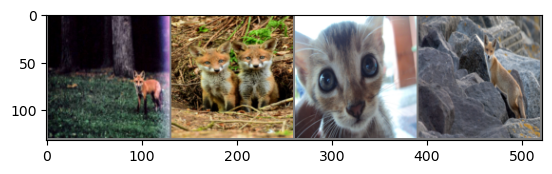

Predicted Labels: dogs foxs cats dogs


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random  # To shuffle and pick random indices

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
classes = dataset.classes

random_indices = random.sample(range(len(test_dataset)), 4)  # Select 4 random indices

random_images = [test_dataset[i][0] for i in random_indices]  # Get the images
random_labels = [test_dataset[i][1] for i in random_indices]  # Get the corresponding labels

random_images_tensor = torch.stack(random_images)

print('True Labels:', ' '.join(f'{classes[random_labels[j]]}' for j in range(4)))
imshow(torchvision.utils.make_grid(random_images_tensor))  # Show the batch of random images

model.eval()  # Set the model to evaluation mode
outputs = model(random_images_tensor)  # Make predictions on the random images
_, predicted = torch.max(outputs, 1)

print('Predicted Labels:', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))


In this code, we selected 4 random images from the test dataset and displayed both the true labels and the model’s predicted labels. The true labels for this batch were "foxs foxs cats foxs", while the model predicted "dogs foxs cats dogs". While the model correctly predicted the class for the second and third images (fox and cat, respectively), it misclassified the first and fourth images as "dogs" instead of "foxs." This indicates that the model still struggles with differentiating between some categories, particularly between "dogs" and "foxs" in this instance. The misclassification may result from the model's limited ability to generalize or capture certain distinctive features between these two classes. Further improvements, such as increasing model complexity or adding more data, may be needed to enhance its accuracy.

Now, let us try googlenet pre-trained model.

## Step 6 : GoogleNet ##

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

googlenet = models.googlenet(pretrained=True)

for param in googlenet.parameters():
    param.requires_grad = False  # Freeze all layers except the last

googlenet.fc = nn.Linear(1024, 3)  # 1024 is the input size of GoogLeNet's final layer

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(googlenet.fc.parameters(), lr=0.001)

print(googlenet)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/shabarivignesh/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████████████████████████████████| 49.7M/49.7M [00:03<00:00, 17.1MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

This code loads a **pretrained GoogleNet (InceptionNet)** model using PyTorch, which was previously trained on a large dataset (ImageNet). All layers of the model are **frozen**, meaning their weights will not be updated during training, except for the **final fully connected layer (googlenet.fc)**. This final layer is replaced with a new fully connected layer that outputs 3 classes (for classifying cats, dogs, and foxes), as the original GoogleNet was designed to classify 1000 classes. The model uses the **cross-entropy loss function**, which is standard for multi-class classification, and the **Adam optimizer** is applied only to the new fully connected layer with a learning rate of 0.001. This setup allows us to fine-tune the last layer of GoogleNet while keeping the rest of the model's learned features intact.

## Step 7 : Training GoogleNet model and comparison with the first model ##

In [117]:
num_epochs = 20 

for epoch in range(num_epochs):
    googlenet.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = googlenet(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize the final layer
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    googlenet.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad(): 
        for images, labels in test_loader:
            outputs = googlenet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Accuracy on the test set after epoch {epoch+1}: {100 * correct / total:.2f}%")


Epoch [1/20], Loss: 0.9395
Accuracy on the test set after epoch 1: 74.38%
Epoch [2/20], Loss: 0.6969
Accuracy on the test set after epoch 2: 85.12%
Epoch [3/20], Loss: 0.5292
Accuracy on the test set after epoch 3: 88.43%
Epoch [4/20], Loss: 0.5033
Accuracy on the test set after epoch 4: 86.78%
Epoch [5/20], Loss: 0.4437
Accuracy on the test set after epoch 5: 90.08%
Epoch [6/20], Loss: 0.3792
Accuracy on the test set after epoch 6: 88.43%
Epoch [7/20], Loss: 0.4336
Accuracy on the test set after epoch 7: 89.26%
Epoch [8/20], Loss: 0.4580
Accuracy on the test set after epoch 8: 89.26%
Epoch [9/20], Loss: 0.3787
Accuracy on the test set after epoch 9: 89.26%
Epoch [10/20], Loss: 0.3889
Accuracy on the test set after epoch 10: 89.26%
Epoch [11/20], Loss: 0.3362
Accuracy on the test set after epoch 11: 90.91%
Epoch [12/20], Loss: 0.3196
Accuracy on the test set after epoch 12: 87.60%
Epoch [13/20], Loss: 0.2930
Accuracy on the test set after epoch 13: 91.74%
Epoch [14/20], Loss: 0.2936
Ac

The GoogleNet model shows a significant improvement over the Simple CNN, quickly reaching a test accuracy of 85.12% by the second epoch and peaking at 92.56% by epoch 17. The model consistently maintains a high accuracy between 88% and 92% across the 20 epochs, demonstrating the effectiveness of transfer learning with a pretrained model. Although the training loss decreases steadily, some fluctuations in test accuracy suggest minor overfitting or the need for further data augmentation. Overall, the model successfully leverages pretrained features to achieve strong performance on the custom dataset.

True Labels: dogs foxs dogs foxs


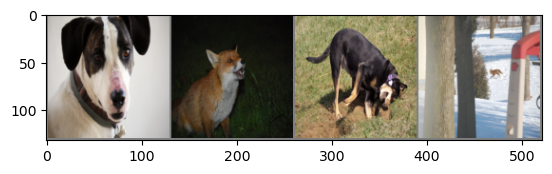

Predicted Labels: dogs foxs dogs foxs


In [119]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random  # To shuffle and pick random indices

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
classes = dataset.classes

random_indices = random.sample(range(len(test_dataset)), 4)  # Select 4 random indices

random_images = [test_dataset[i][0] for i in random_indices]  # Get the images
random_labels = [test_dataset[i][1] for i in random_indices]  # Get the corresponding labels

random_images_tensor = torch.stack(random_images)

print('True Labels:', ' '.join(f'{classes[random_labels[j]]}' for j in range(4)))
imshow(torchvision.utils.make_grid(random_images_tensor))  # Show the batch of random images

googlenet.eval()  # Set the model to evaluation mode
outputs = googlenet(random_images_tensor)  # Make predictions on the random images
_, predicted = torch.max(outputs, 1)

print('Predicted Labels:', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))


In this code, we randomly selected 4 images from the test dataset and used the pretrained GoogleNet model to make predictions. The true labels for this batch were "dogs foxs dogs foxs," and the model correctly predicted all of them as "dogs foxs dogs foxs." This result demonstrates that the fine-tuned GoogleNet model is accurately classifying the selected test images. The model has successfully learned to distinguish between the categories (dogs, cats, and foxes) and is generalizing well to unseen data, as shown by its ability to make correct predictions for all the randomly chosen images in this batch.

### Comparison of Simple CNN Model and GoogleNet Model

| Aspect                     | Simple CNN Model                          | GoogleNet Model                           |
|-----------------------------|-------------------------------------------|-------------------------------------------|
| **Architecture**            | 2 convolutional layers, 1 fully connected layer with 128 units and dropout | Pretrained GoogleNet (InceptionNet), fine-tuned with 1 new fully connected layer for 3 classes |
| **Initial Test Accuracy**    | 50.41% after epoch 1                      | 74.38% after epoch 1                      |
| **Best Test Accuracy**       | 61.98% after 20 epochs                    | 92.56% after 17 epochs                    |
| **Training Loss (Final)**    | 0.3892 after 20 epochs                    | 0.2668 after 20 epochs                    |
| **Fluctuations in Accuracy** | Test accuracy fluctuated around 50-60%    | Test accuracy remained consistently high between 88-92% |
| **Overfitting**              | Potential minor overfitting, slow generalization improvement | Minor overfitting, but good generalization to unseen data |
| **Prediction Example**       | Misclassified 2 out of 4 random test images | Correctly classified all 4 random test images |

### Key Takeaways:
- **GoogleNet Model** significantly outperforms the **Simple CNN Model** in terms of both accuracy and generalization, achieving a test accuracy of **92.56%** compared to **61.98%** for the Simple CNN.
- The **Simple CNN Model** showed slower improvement in test accuracy and was more prone to overfitting, whereas the **GoogleNet Model** quickly converged due to its pretrained layers and demonstrated more stable performance.
- In the random image testing, GoogleNet correctly classified all images, while the Simple CNN struggled with misclassifications.